In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, scale
from sklearn import metrics as mt # mean_squared_error, confusion_matrix, roc_auc_score
from sklearn.neighbors import NearestNeighbors

Imports the cleaned data set (from HealthCost_data_cleaning notebook)

In [10]:
df=pd.read_csv('data/IPPS_Data_Clean.csv', \
               dtype={'provider_id':str,'provider_zip_code':str, 'drg_id':str,'total_discharges':float})

#df['provider_city_state'] = df.provider_city + ', ' + df.provider_state
df.head(3)

,drg_id,drg_definition,provider_id,provider_name,provider_street_address,provider_city,provider_state,provider_zip_code,hospital_referral_region_description,total_discharges,average_covered_charges,average_total_payments,average_medicare_payments
0,039,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91.0,32963.07,5777.24,4763.73
1,039,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14.0,15131.85,5787.57,4976.71
2,039,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24.0,37560.37,5434.95,4453.79


Calculates the national median cost for each procedure

In [11]:
natmed = pd.DataFrame(df.groupby('drg_id',sort=False)['average_covered_charges'].median()).reset_index()
natmed = natmed.rename(columns={'average_covered_charges':'median_covered_charges'})
natmed.head()

,drg_id,median_covered_charges
0,039,26651.000
1,057,20453.050
2,069,18342.265
3,064,40953.590
4,065,25151.470


Adds a column that is the fractional difference in total charges from the national median (for that particular procedure)

In [12]:
procedures=df.drg_id.unique()

for i in procedures:    
    sel = df.drg_id == i
    med = natmed.loc[natmed.drg_id == i,'median_covered_charges'].iloc[0]
    
    df.loc[sel,'frac_diff'] = df.loc[sel,'average_covered_charges']/med - 1.0

df.head(3)

,drg_id,drg_definition,provider_id,provider_name,provider_street_address,provider_city,provider_state,provider_zip_code,hospital_referral_region_description,total_discharges,average_covered_charges,average_total_payments,average_medicare_payments,frac_diff
0,039,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91.0,32963.07,5777.24,4763.73,0.236842
1,039,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14.0,15131.85,5787.57,4976.71,-0.432222
2,039,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24.0,37560.37,5434.95,4453.79,0.409342


In [16]:
df_uniqprov = df.drop_duplicates(subset='provider_id')
df_uniqprov = df_uniqprov.drop(['drg_id','drg_definition']+list(df.columns[9:14]),axis=1)

fm = pd.DataFrame(df.groupby('provider_id',sort=False)['frac_diff'].mean()).reset_index()
df_uniqprov = df_uniqprov.merge(fm,on='provider_id')

df = df_uniqprov
df.head()

,provider_id,provider_name,provider_street_address,provider_city,provider_state,provider_zip_code,hospital_referral_region_description,frac_diff
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,0.045061
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,-0.381475
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,0.063646
3,10011,ST VINCENTS EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,-0.136274
4,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,0.305562


GPS locations of every unique provider.

In [17]:
dfprov=pd.read_csv('data/Providers_Geocode.csv',usecols=['provider_id','lat','lng'],dtype={'provider_id':str})
dfprov.head(3)

,provider_id,lat,lng
0,10001,31.216725,-85.363068
1,10005,34.221556,-86.159441
2,10006,34.793845,-87.683155


In [ ]:
# dfins = pd.read_csv('InsuranceCoverage_Adults16-64.csv',usecols=['Location','Uninsured'])#,encoding='Latin')
# dfins=dfins[1:].reset_index(drop=True)#.head()

# # Dataframe that lists states and their abbreviations for mapping
# abbrev = pd.read_csv('states.csv').rename(columns={'State':'Location','Abbreviation':'provider_state'})
# dfins = dfins.merge(abbrev,on ='Location')[['provider_state','Uninsured']]
# dfins.head()

Population by state dataframe (Census.gov)

In [18]:
dfstates=pd.read_csv('data/NST-EST2015-alldata.csv',usecols=['NAME','POPESTIMATE2011'])#,dtype={'POPESTIMATE2011':float})
dfstates = dfstates[5:56].reset_index(drop=True)

# Dataframe that lists states and their abbreviations for mapping
abbrev = pd.read_csv('data/states.csv').rename(columns={'State':'NAME','Abbreviation':'provider_state'})

dfstates = dfstates.merge(abbrev,on ='NAME')
dfstates = dfstates[['provider_state','POPESTIMATE2011']]#,'RBIRTH2011','RDEATH2011']]
dfstates = dfstates.rename(columns={'POPESTIMATE2011':'state_population2011'})

dfstates.head(3)

,provider_state,state_population2011
0,AL,4801108
1,AK,722720
2,AZ,6468732


Population by city dataframe (Census.gov)

In [ ]:
# dfcities = pd.read_csv('data/SUB-EST2015_ALL.csv',encoding='latin-1',usecols=['SUMLEV','NAME','STNAME','POPESTIMATE2011'])
# dfcities = dfcities[(dfcities.SUMLEV == 162) | (dfcities.SUMLEV == 170)]
# print(len(dfcities))
# # Dataframe that lists states and their abbreviations for mapping
# abbrev = pd.read_csv('data/states.csv').rename(columns={'State':'STNAME','Abbreviation':'provider_state'})

# dfcities = dfcities.merge(abbrev,on ='STNAME')
# dfcities = dfcities[['NAME','provider_state','POPESTIMATE2011']]
# dfcities = dfcities.rename(columns={'NAME':'provider_city','POPESTIMATE2011':'city_population2011'})

# #removes ' city' and ' town' from end of name
# dfcities.provider_city = dfcities.provider_city.map(lambda x: str(x)[:-5]).str.upper()

# dfcities['provider_city_state'] = dfcities.provider_city + ', ' +dfcities.provider_state
# dfcities = dfcities[['provider_city_state','city_population2011']]
# print(len(dfcities))
# dfcities.head()

In [ ]:
# dfcities[(dfcities.NAME.map(lambda x: str(x)[-5:]) != ' town') & \
#          (dfcities.NAME.map(lambda x: str(x)[-5:]) != ' city') & \
#          (dfcities.NAME.map(lambda x: str(x)[-13:]) != ' municipality') & \
#          (dfcities.NAME.map(lambda x: str(x)[-8:]) != ' borough') & \
#          (dfcities.NAME.map(lambda x: str(x)[-8:]) != ' village')].reset_index()

Population by zip code dataframe (http://notnullhypothesis.com/2010-census-data-by-zip-code-population/)

In [19]:
#dfzip = pd.read_csv('2010CensusPopulationData.csv',usecols=['Zip','Population'],dtype={'Zip':str})
dfzip = pd.read_csv('data/Zipcode-ZCTA-Population-Density-And-Area-Unsorted.csv', \
                   dtype={'Zip':str},usecols=['Zip','2010 Population','Density Per Sq Mile'])
dfzip.Zip = dfzip.Zip.str.zfill(5)
dfzip = dfzip.rename(columns = {'Zip':'provider_zip_code','2010 Population':'zip_population2010', \
                               'Density Per Sq Mile':'zip_pop2010_density'})
dfzip.head()

,provider_zip_code,zip_population2010,zip_pop2010_density
0,00601,0,0.0
1,00602,0,0.0
2,00603,0,0.0
3,00606,0,0.0
4,00610,0,0.0


Median income by zipcode (http://www.psc.isr.umich.edu/dis/census/Features/tract2zip/)

In [20]:
dfincome = pd.read_csv('data/MedianZIP-3.csv',dtype={'Zip':str},usecols=['Zip','Median'])

dfincome.Zip = dfincome.Zip.str.zfill(5)
dfincome.Median = dfincome.Median.str.replace(',','').astype(int)
dfincome = dfincome.rename(columns={'Zip':'provider_zip_code','Median':'zip_median_income'})

dfincome.head()

,provider_zip_code,zip_median_income
0,01001,56663
1,01002,49853
2,01003,28462
3,01005,75423
4,01007,79076


Combines all into one dataframe and selects the relevant columns

In [42]:
#df['provider_city_state'] = df.provider_city + ', ' + df.provider_state

dftot = df.merge(dfprov, on='provider_id')
#dftot = dftot.merge(dfins,on='provider_state')
#dftot = dftot.merge(dfstates, on='provider_state')
#dftot = dftot.merge(dfzip, on='provider_zip_code')
#dftot = dftot.merge(dfcities, on=['provider_city_state'])
dftot = dftot.merge(dfincome, on='provider_zip_code')
#dftot = dftot.drop([list(dftot.columns)[1]]+list(dftot.columns)[3:5]+list(dftot.columns)[11:13],axis=1)
#dftot.head()
#dftot.provider_id.nunique()
len(dftot)

3165

In [43]:
dftot['frac_diff_class'] = dftot.frac_diff >= 0.0
dftot.head(3)

,provider_id,provider_name,provider_street_address,provider_city,provider_state,provider_zip_code,hospital_referral_region_description,frac_diff,lat,lng,zip_median_income,frac_diff_class
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,0.045061,31.216725,-85.363068,38008,True
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,-0.381475,34.221556,-86.159441,33993,False
2,10011,ST VINCENTS EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,-0.136274,33.596457,-86.667650,54491,False


In [44]:
dftot.groupby('frac_diff_class').size()

frac_diff_class
False    1800
True     1365
dtype: int64

For each provider, calculates the number of other providers within a 40 mile radius.

In [ ]:
from geopy.distance import vincenty
import time

In [ ]:
%%time
dfprov['n_hosp'] = 0.0

pts = [dfprov.lat,dfprov.lng]
pts = list(list(x) for x in zip(*pts))
i=0

for index, row in dfprov[['lat','lng']].iterrows():
    count = 0
    pt1 = [row.lat,row.lng]
    
    for pt in pts:
        dist = vincenty(pt1, pt).miles
        if dist < 40 and dist > 0:
            count +=1
            
    dfprov.loc[index,'n_hosp'] = count
    i+=1
    if i % 1000 == 0: print(i)

In [ ]:
dfprov.head()

In [ ]:
dftot = dftot.merge(dfprov[['provider_id','n_hosp']], on='provider_id' )

In [ ]:
dftot.head()

Random Forest Classifier using entire dataset

In [48]:
inx = ['lat','lng']#'provider_city']#,'zip_pop2010_density','zip_population2010','zip_median_income']#,'provider_id']#['lat','lng']#
dfX = dftot.loc[:,inx]#zip_population2010']]
dfY = dftot.loc[:,'frac_diff_class']

dfX.head()

,lat,lng
0,31.216725,-85.363068
1,34.221556,-86.159441
2,33.596457,-86.667650
3,33.252444,-86.813555
4,32.326946,-86.271034


In [49]:
# dfX = pd.get_dummies(dfX, columns=['provider_city'], dummy_na=True)
# dfX.head()

In [51]:
rf = RandomForestClassifier(n_jobs=-1)
#rf.n_estimators=10

X_train, X_test, y_train, y_test = train_test_split(dfX, dfY, train_size=2./3)

rf.fit(X_train,y_train)

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

rf.score(X_test,y_test)

0.75165876777251184

In [52]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    tick_label = ['f < 0','f > 0']
    plt.xticks(tick_marks, tick_label, rotation=45)
    plt.yticks(tick_marks, tick_label)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix
[[483 115]
 [147 310]]
Normalized confusion matrix
[[ 0.80769231  0.19230769]
 [ 0.32166302  0.67833698]]


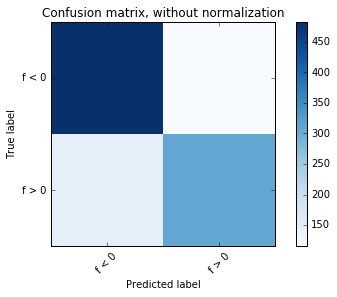

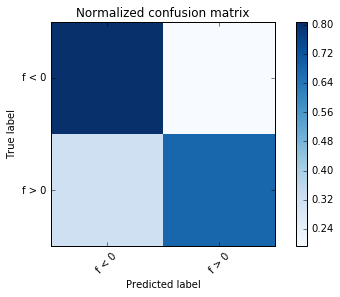

In [53]:
cm = mt.confusion_matrix(y_test, y_test_pred)

print('Confusion matrix')
print(cm)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)


plt.figure()
plot_confusion_matrix(cm,title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

AUC Score = 0.810575733847


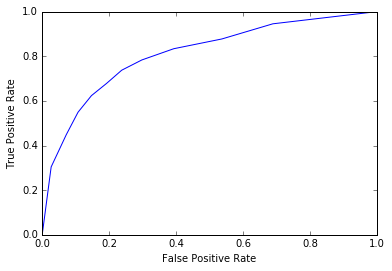

In [54]:
y_score = rf.predict_proba(X_test)[:,1]

print('AUC Score =',mt.roc_auc_score(y_test, y_score))
fpr, tpr, thresholds = mt.roc_curve(y_test,y_score)
plt.figure()
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [ ]:
dftmp = dftot.loc[y_test.index][['provider_state','frac_diff_class']]
dftmp['frac_diff_class_pred'] = y_test_pred
dftmp['class_pred'] = dftmp.frac_diff_class == dftmp.frac_diff_class_pred
dftmp.head()

In [ ]:
df_state_pred = dftmp.groupby(['provider_state','class_pred']).size().unstack()
df_state_pred['Percent'] = df_state_pred[df_state_pred.columns[1]]/df_state_pred.sum(axis=1)
df_state_pred.head()

In [ ]:
df_state_pred.plot(y='Percent',kind='bar',figsize=(25,12),fontsize=20);

In [ ]:
#finds the median gps coordinates of all providers in each state
df_state_geo = dftot[['provider_state','lat','lng']]
df_state_geo = df_state_geo.groupby(['provider_state']).median()
df_state_geo.head()

In [ ]:
df_state = df_state_pred.merge(df_state_geo,right_index=True,left_index=True)
df_state.head()

In [ ]:
df_state.sort_values('lng').plot(y = 'Percent',kind ='bar',figsize=(20,10));